https://arxiv.org/abs/2007.14044

In [715]:
!pip3 install qiskit --upgrade

Defaulting to user installation because normal site-packages is not writeable


In [716]:
import qiskit
from scipy.special import erfinv
import numpy as np
import pandas as pd
import scipy as sp
from sklearn.model_selection import train_test_split

qs = qiskit.Aer.get_backend('qasm_simulator')

# Useful functions

## Preprocessing functions

In [769]:
def standardise(x):
    return (x - np.mean(x)) / np.std(x)

def rescaleFeature(x, alpha, q):
    return (1-alpha/2) * (np.pi/q) * standardise(x)

## Circuit functions

In [718]:
def psiGate(qc, param, bit):
    qc.rx(np.pi/2, bit)
    qc.rz(param, bit)
    qc.rx(np.pi/2, bit)

## Training functions

In [719]:
def executeJob(circuit, nshots):
    job = qiskit.execute(circuit, shots=nshots, backend=qs)
    job_results = job.result().get_counts()
    return job_results


In [720]:
def runCircuit(circuit_builder, loss_function, theta, x, y, bitstrings, nshots):
    omega = x
    label = y
    
    circuit = circuit_builder(theta, omega)
    job_results = executeJob(circuit, nshots)
    return loss_function(label, job_results, bitstrings, nshots)

In [721]:
def logSoftmax(label, job_results, bitstrings, nshots) :
    if label in job_results :
        e = np.exp(job_results[label] / nshots)
    else :
        e = 1
        
    s = 0
    for bitstring in bitstrings :
        if bitstring in job_results :
            s += np.exp(job_results[bitstring] / nshots)
        else :
            s += 1 
            
    return -np.log(e / s)


In [722]:
def lossBatch(circuit_builder, loss_function, theta, X, y, bitstrings, nshots):
    
    total_loss = 0
    
    batch = list(zip(X, y))
    
    for X_el, y_el in zip(X, y) :
        total_loss += runCircuit(circuit_builder, logSoftmax, theta, X_el, y_el, bitstrings, nshots)
        
    total_loss /= len(y)
    return total_loss

In [768]:
def fit(circuit_builder, loss_function, X, y, bitstrings, nshots=100, maxiter=20, theta=None, theta_size=8):
    if theta is None:
        theta = np.random.uniform(0, 2 * np.pi, theta_size)
        
    opt = sp.optimize.minimize(
        fun=lambda params : lossBatch(circuit_builder, loss_function, params, X, y, bitstrings, nshots),
        x0=theta,
        method='COBYLA',
        options={'maxiter': maxiter}
    )
    return opt

## Testing functions

In [724]:
def argmaxJobResults(job_results, bistrings):
    max_label_value = None
    max_label = None
    
    for label in job_results :
        if label in bistrings and (max_label_value is None or job_results[label] >= max_label_value) :
            max_label = label
            max_label_value = job_results[label]
    return max_label

In [725]:
def predict(circuit_builder, theta, X, bistrings, nshots=100):
    y_pred = []
    
    for omega in X :    
        circuit = circuit_builder(theta, omega)
        job_results = executeJob(circuit, nshots)
        y_pred.append(argmaxJobResults(job_results, bistrings))
        
    return y_pred

In [726]:
def compute_accuracy(y_pred, y) :
    correct = 0
    
    for y_pred_el, y_el in zip(y_pred, y) :
        if y_pred_el == y_el :
            correct += 1
        
    return correct / len(y)

# IRIS

## Construct dataset

### Preprocess

In [727]:
df = pd.read_csv("iris.data")
df

,sepal-length,sepal-width,petal-length,petal-width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


In [728]:
alpha = 0.1
q = 3

#q = 3 fixé dans le papier

attributes = df.columns[:-1]

for x in attributes:
    df[x] = rescaleFeature(df[x], alpha, q)

df

,sepal-length,sepal-width,petal-length,petal-width,class
0,-0.896032,1.026729,-1.334348,-1.306199,Iris-setosa
1,-1.137116,-0.124313,-1.334348,-1.306199,Iris-setosa
2,-1.378201,0.336104,-1.390920,-1.306199,Iris-setosa
3,-1.498743,0.105896,-1.277776,-1.306199,Iris-setosa
4,-1.016574,1.256938,-1.334348,-1.306199,Iris-setosa
...,...,...,...,...,...
145,1.032646,-0.124313,0.815393,1.440481,Iris-virginica
146,0.550477,-1.275354,0.702249,0.917304,Iris-virginica
147,0.791562,-0.124313,0.815393,1.048098,Iris-virginica
148,0.429934,0.796521,0.928537,1.440481,Iris-virginica


In [729]:
diconvert = {
    "Iris-setosa" : "00",
    "Iris-versicolor" : "01",
    "Iris-virginica" : "10"
}

df = df.replace({"class": diconvert})
df

,sepal-length,sepal-width,petal-length,petal-width,class
0,-0.896032,1.026729,-1.334348,-1.306199,00
1,-1.137116,-0.124313,-1.334348,-1.306199,00
2,-1.378201,0.336104,-1.390920,-1.306199,00
3,-1.498743,0.105896,-1.277776,-1.306199,00
4,-1.016574,1.256938,-1.334348,-1.306199,00
...,...,...,...,...,...
145,1.032646,-0.124313,0.815393,1.440481,10
146,0.550477,-1.275354,0.702249,0.917304,10
147,0.791562,-0.124313,0.815393,1.048098,10
148,0.429934,0.796521,0.928537,1.440481,10


In [730]:
X = df[attributes].values
y = df["class"].values

### Split

In [731]:
train_size = 90
test_size = 60

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, train_size=train_size, stratify=y)

## Circuit

In [732]:
def irisCircuit(theta, omega):
    qc = qiskit.QuantumCircuit(2, 2)
    
    iris_circuit = qiskit.QuantumCircuit(2)
    for i in range(4):
        if i : iris_circuit.cz(0, 1)
        psiGate(iris_circuit, omega[(2*i) % 4], 0)
        psiGate(iris_circuit, omega[(2*i+1) % 4], 1)
        
        iris_circuit.cz(0, 1)
        
        psiGate(iris_circuit, theta[(2*i)], 0)
        psiGate(iris_circuit, theta[(2*i+1)], 1)
        
    qc.append(iris_circuit, range(2))
    qc.measure(range(2), range(2))
    
    return qc

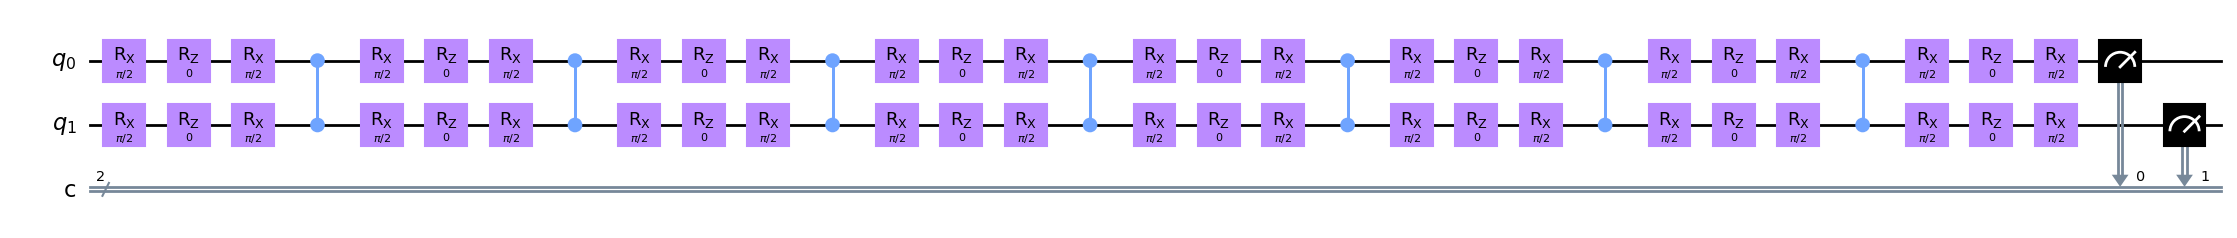

In [766]:
irisCircuit(np.zeros(8), np.zeros(4)).decompose().draw("mpl", fold=40)

## Train

In [733]:
opt = fit(irisCircuit, logSoftmax, X_train, y_train, ['00', '01', '10'], nshots=250, maxiter=20)
theta = opt.x
opt

     fun: 0.9518248331280252
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 20
  status: 2
 success: False
       x: array([ 3.06200771,  0.81821834,  6.15824901,  4.85207515,  3.43335895,
       -1.07904102,  1.98449375,  0.32744897])

In [734]:
opt = fit(irisCircuit, logSoftmax, X_train, y_train, ['00', '01', '10'], nshots=500, maxiter=30, theta=theta)
theta = opt.x
opt

     fun: 0.8715829588254953
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 30
  status: 2
 success: False
       x: array([ 3.07167564,  1.04979556,  6.09281097,  4.19899885,  2.45710841,
       -2.17045694,  2.10807849,  0.55623502])

In [735]:
opt = fit(irisCircuit, logSoftmax, X_train, y_train, ['00', '01', '10'], nshots=750, maxiter=70, theta=theta)
theta = opt.x
opt

     fun: 0.7330176107758304
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 70
  status: 2
 success: False
       x: array([ 2.4212917 ,  0.37378763,  6.04867638,  2.96794213,  1.23310036,
       -2.16251073,  0.65102167,  1.21993043])

## Compute results

In [736]:
y_pred = predict(irisCircuit, theta, X_train, ['00', '01', '10'], 100)
compute_accuracy(y_pred, y_train)

0.9333333333333333

In [737]:
y_pred = predict(irisCircuit, theta, X_test, ['00', '01', '10'], 100)
compute_accuracy(y_pred, y_test)

0.9166666666666666

# Gaussian XOR

### Generate dataset

In [738]:
import numpy as np
import math

In [739]:
def generate_gaussian_point(x, y, label) :
    pick_x = np.random.normal(loc=x, scale = 0.5)
    pick_y = np.random.normal(loc=y, scale = 0.5)
    return (pick_x, pick_y, label)

In [740]:
#dans le papier ils utilisent 1.5 et non pi / 2, a tester...

center1 = (-np.pi / 2, 0)
center2 = (np.pi / 2, 0)
center3 = (0, -np.pi / 2)
center4 = (0, np.pi / 2)

centers = [center1, center2, center3, center4]


In [741]:
points = []
for i in range(20) :
    points.append(generate_gaussian_point(*point1, 0))
    points.append(generate_gaussian_point(*point2, 0))
    points.append(generate_gaussian_point(*point3, 1))
    points.append(generate_gaussian_point(*point4, 1))


(-3.141592653589793, 3.141592653589793)

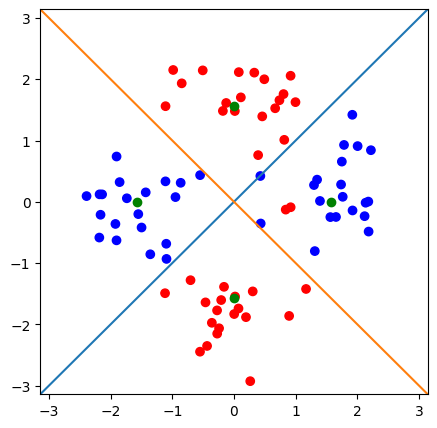

In [742]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [5,5]

x,y,c = zip(*points)
c = ["blue" if el==0 else "red" for el in c]
plt.scatter(x, y, color=c)
x,y = zip(*centers)
plt.scatter(x, y, color='green')



x = np.linspace(-np.pi, np.pi, 100)
y = x
y2 = - x

plt.plot(x,y)
plt.plot(x,y2)

plt.xlim([-np.pi, np.pi])
plt.ylim([-np.pi, np.pi])

In [743]:
dataset = np.array(points)
dataset[:10]

array([[-0.54914364,  0.43472986,  0.        ],
       [ 1.76338809,  0.08126429,  0.        ],
       [-0.27195728, -2.15186741,  1.        ],
       [-0.98565653,  2.15078834,  1.        ],
       [-2.39033967,  0.09290474,  0.        ],
       [ 2.22050292,  0.84174507,  0.        ],
       [-0.20743963, -1.60382974,  1.        ],
       [ 0.80375437,  1.75764637,  1.        ],
       [-2.17919695,  0.12143074,  0.        ],
       [ 1.91903737,  1.41965498,  0.        ]])

### Preprocess dataset

In [744]:
X = dataset[:, :2]
X[:10]

array([[-0.54914364,  0.43472986],
       [ 1.76338809,  0.08126429],
       [-0.27195728, -2.15186741],
       [-0.98565653,  2.15078834],
       [-2.39033967,  0.09290474],
       [ 2.22050292,  0.84174507],
       [-0.20743963, -1.60382974],
       [ 0.80375437,  1.75764637],
       [-2.17919695,  0.12143074],
       [ 1.91903737,  1.41965498]])

In [745]:
diconvert = {
    0 : "00",
    1 : "10",
}

y = [diconvert[x] for x in dataset[:,2]]
y[:10]

['00', '00', '10', '10', '00', '00', '10', '10', '00', '00']

## Circuit

In [746]:
def xorCircuit(theta, omega):
    qc = qiskit.QuantumCircuit(2, 2)
    
    xor_circuit = qiskit.QuantumCircuit(2)
    
    psiGate(xor_circuit, omega[0], 0)
    psiGate(xor_circuit, omega[1], 1)
    
    for i in range(2):
        xor_circuit.cz(0, 1)
        psiGate(xor_circuit, theta[2*i], 0)
        psiGate(xor_circuit, theta[2*i+1], 1)
        
    
    qc.append(xor_circuit, range(2))
    qc.measure(range(2), range(2))
    return qc

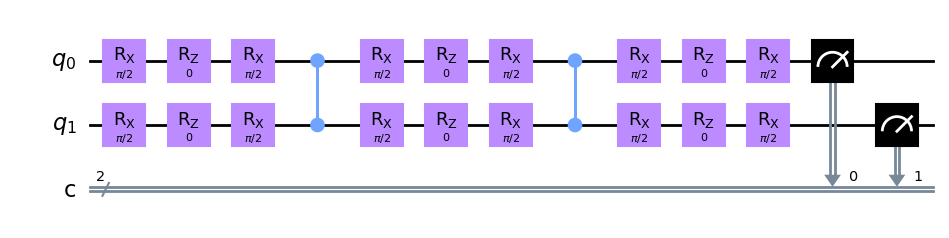

In [767]:
xorCircuit(np.zeros(8), np.zeros(4)).decompose().draw("mpl", fold=40)

## Train

In [747]:
xor_opt = fit(xorCircuit, logSoftmax, X, y, ['00', '10'], nshots=250, maxiter=80, theta_size=4)
theta = xor_opt.x
xor_opt

     fun: 0.4942366491138979
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 52
  status: 1
 success: True
       x: array([ 4.69459361,  6.25475296, -1.56009943,  2.99623303])

## Compute results

In [748]:
y_pred = predict(xorCircuit, theta, X, ['00', '10'], 100)
compute_accuracy(y_pred, y)

0.9625

In [749]:
lin = np.linspace(-np.pi, np.pi, num = 50)
X_test = np.array([[x, y] for x in lin for y in lin])

y_test = ["10" if abs(el[0]) < abs(el[1]) else "00" for el in X_test]

In [750]:
y_pred = predict(xorCircuit, theta, X_test, ['00', '10'], 100)

(-3.141592653589793, 3.141592653589793)

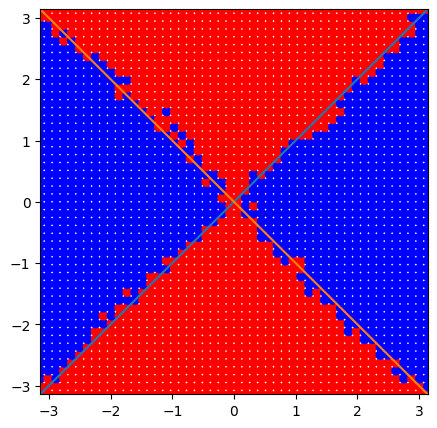

In [751]:
plt.rcParams['figure.figsize'] = [5,5]


c = ["blue" if el=="00" else "red" for el in y_pred]
plt.scatter(X_test[:, 0], X_test[:, 1], color=c)

x = np.linspace(-np.pi, np.pi, 100)
y = x
y2 = - x

plt.plot(x,y)
plt.plot(x,y2)

plt.xlim([-np.pi, np.pi])
plt.ylim([-np.pi, np.pi])

In [752]:
compute_accuracy(y_pred, y_test)

0.9492

## Compare with GaussianNB

In [753]:
from sklearn.naive_bayes import GaussianNB

In [754]:
gaussianNb = GaussianNB()

X_train = dataset[:, :2]
y_train = dataset[:,2]

gaussianNb.fit(X_train, y_train)

y_test = [1 if abs(el[0]) < abs(el[1]) else 0 for el in X_test]

score = gaussianNb.score(X_test, y_test)

In [755]:
score

0.916

# Skin segmentation

In [756]:
def skinSegCircuit(theta, omega):
    qc = qiskit.QuantumCircuit(3)
    psiGate(qc, omega[0], 0)
    psiGate(qc, omega[1], 1)
    psiGate(qc, omega[2], 2)
    
    qc.cz(0, 2)
    
    psiGate(qc, theta[0], 0)
    psiGate(qc, theta[1], 2)
    
    qc.cz(0, 1)
    
    psiGate(qc, theta[2], 0)
    psiGate(qc, theta[3], 1)
    
    qc.cz(1, 2)
    
    psiGate(qc, theta[4], 1)
    psiGate(qc, theta[5], 2)
    return qc

# Synthetic dataset with 4 classes

In [ ]:
def syntheticCircuit(theta, omega):
    qc = qiskit.QuantumCircuit(2)
    for i in range(2):
        if i : qc.cz(0, 1)
        psiGate(qc, omega[0], 0)
        psiGate(qc, omega[1], 1)
        qc.cz(0, 1)
        psiGate(qc, theta[(6*i)], 0)
        psiGate(qc, theta[(6*i+1)], 1)
        qc.cz(0, 1)
        psiGate(qc, omega[0], 0)
        psiGate(qc, omega[1], 1)
        qc.cz(0, 1)
        psiGate(qc, theta[(6*i+2)], 0)
        psiGate(qc, theta[(6*i+3)], 1)
        qc.cz(0, 1)
        psiGate(qc, theta[(6*i+4)], 0)
        psiGate(qc, theta[(6*i+5)], 1)
    return qc

# Run on IBM Quantum Computer

In [ ]:
TOKEN = ...

In [ ]:
qiskit.IBMQ.save_account(TOKEN, overwrite=True) 
provider = qiskit.IBMQ.load_account()
backend = qiskit.providers.ibmq.least_busy(provider.backends())

mapped_circuit = qiskit.transpile(circuit, backend=backend)
qobj = qiskit.assemble(mapped_circuit, backend=backend, shots=1024)

IBMQAccountCredentialsInvalidToken: 'Invalid IBM Quantum Experience token found: "Ellipsis" of type <class \'ellipsis\'>.'

In [ ]:
# execute the circuit
job = backend.run(qobj)


In [ ]:
job.status()


In [ ]:
ID = job.job_id()

In [ ]:
job = backend.retrieve_job(ID)

In [ ]:
result = job.result()

In [ ]:
counts = result.get_counts()

In [ ]:
counts